In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Phylo.PhyloXML import Phyloxml
from Bio.Phylo import PhyloXMLIO
from cen_detect_hor.distance import distance_values
from cen_detect_hor.showHOR import show_hor, show_hors, show_hor_tree
from cen_detect_hor.featureUtils import BED_file_to_features, feature_to_seq, remove_overlapping_features
from cen_detect_hor.parallel_distance import build_seqs_distance_matrix_by_chunks, FileSystemChunkStore
from cen_detect_hor.hor_tree import phylogeny_to_hor_tree
from cen_detect_hor.clustering_to_phylogeny import clustering_to_phylogeny
from cen_detect_hor.mixed_direction_hors import find_inversion_loops
from cen_detect_hor.compare_phylogenies import phylogenies_equal

In [2]:
references = {seq.id : seq for seq in SeqIO.parse("./data/chr4_human/HSA.chr4.fasta", "fasta")}

In [3]:
monomers_as_features = BED_file_to_features("./data/chr4_human/final_decomposition.bed")

In [4]:
monomers_as_features = remove_overlapping_features(
    features=monomers_as_features,
    expected_feature_size=171,
    max_allowed_overlap_fraction=0.25
)

Removed sequence feature chr4:44699037-59858846[10510080:10510252](-) overlapping (109 bps) with sequence feature chr4:44699037-59858846[10510018:10510189](+).
Removed sequence feature chr4:44699037-59858846[10585033:10585192](+) overlapping (109 bps) with sequence feature chr4:44699037-59858846[10585083:10585254](-).


/Users/miguel/git/CENdetectHOR_lib/env/lib/python3.9/site-packages/Bio/SeqFeature.py:260: BiopythonDeprecationWarning: Please use .location.ref rather than .ref
  warnings.warn(


In [5]:
# sample monomers for testing purposes (comment out for complete analysis)

# sample_size = 60
# num_samples = 5

# sample_page = len(monomers_as_features) // num_samples
# sample_offset = (sample_page - sample_size) // 2

# def slice_seq(seq, position, length):
#     return seq[position : position + length]

# monomers_as_features = [
#     monomer
#     for sample_index in range(num_samples)
#     for monomer in slice_seq(monomers_as_features, sample_index * sample_page + sample_offset, sample_size)
# ]

In [6]:
monomers_as_seqs = [feature_to_seq(feature, references) for feature in monomers_as_features]

In [7]:
monomer_dists = build_seqs_distance_matrix_by_chunks(monomers_as_seqs, num_chunks=32, chunk_store=FileSystemChunkStore("data/chr4_human/submatrices_32/piece_{row}_{col}"))

# of chunks for computing distance matrix: 32
Chunk size: 24
Num processes: 481
Blocks: ['([0:1](24,24))', '([0:2](24,24))', '([1:2](24,24))', '([0:3](24,24))', '([1:3](24,24))', '([2:3](24,24))', '([0:4](24,24))', '([1:4](24,24))', '([2:4](24,24))', '([3:4](24,24))', '([0:5](24,24))', '([1:5](24,24))', '([2:5](24,24))', '([3:5](24,24))', '([4:5](24,24))', '([0:6](24,24))', '([1:6](24,24))', '([2:6](24,24))', '([3:6](24,24))', '([4:6](24,24))', '([5:6](24,24))', '([0:7](24,24))', '([1:7](24,24))', '([2:7](24,24))', '([3:7](24,24))', '([4:7](24,24))', '([5:7](24,24))', '([6:7](24,24))', '([0:8](24,24))', '([1:8](24,24))', '([2:8](24,24))', '([3:8](24,24))', '([4:8](24,24))', '([5:8](24,24))', '([6:8](24,24))', '([7:8](24,24))', '([0:9](24,24))', '([1:9](24,24))', '([2:9](24,24))', '([3:9](24,24))', '([4:9](24,24))', '([5:9](24,24))', '([6:9](24,24))', '([7:9](24,24))', '([8:9](24,24))', '([0:10](24,24))', '([1:10](24,24))', '([2:10](24,24))', '([3:10](24,24))', '([4:10](24,24))', '([5:1

In [8]:
with open('data/chr4_human/distances.npy', 'wb') as f:
    np.save(f, monomer_dists)

(array([ 5411.,  3158.,  1647.,   619.,   397.,   199.,   179.,   145.,
           89.,    57.,    57.,   132.,   208.,   331.,   196.,   114.,
          127.,    95.,   134.,   449.,  1580.,  1907.,  2050.,  1992.,
          738.,   609.,  1817.,  5861.,  6287.,  5245.,  6074.,  3452.,
         3868.,  2629.,  7484.,  3970.,  6029.,  4400.,  5328.,  9248.,
         8870.,  8999.,  9423., 12659., 11950., 10248., 15872., 13862.,
        15492., 12966.,  7765.,  6567.,  3529.,  3967.,  3669.,  2732.,
         1349.,   803.,   334.,   165.,   103.,    96.,   217.,   122.,
           72.,   124.,   142.,   163.,   232.,   134.,   111.,   170.,
          129.,   182.,   101.,    81.,   265.,   190.,   152.,   242.,
          255.,   676.,   949.,  1559.,  2287.,  2869.,  2919.,  2976.,
         3135.,  2593.,  2392.,  1303.,   734.,   381.,   235.,   139.,
           89.,    52.,    66.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 1

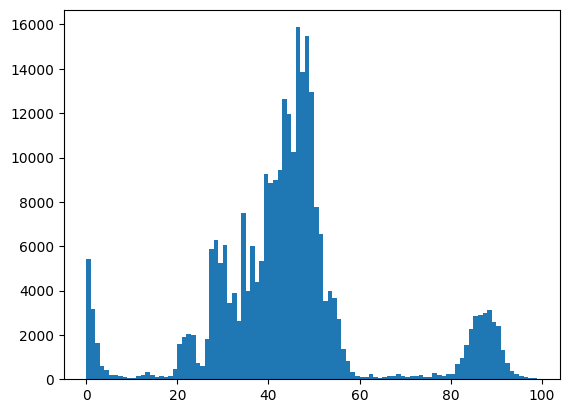

In [9]:
dist_values = distance_values(monomer_dists)
plt.hist(dist_values, bins=int(max(dist_values)))

In [10]:
# plt.matshow(monomer_dists)

In [11]:
clustering_res = clustering_to_phylogeny(
    dist_matrix=monomer_dists,
    items_as_seq_features=monomers_as_features,
    seq_references=references
)
phylogeny = clustering_res.phylogeny

In [12]:
phyloXml = Phyloxml(phylogenies=[phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, './data/chr4_human/monomer_phylogeny.xml')

1

In [13]:
hor_tree = phylogeny_to_hor_tree(phylogeny, min_loops=5, allow_hor_overlap=False)

/Users/miguel/git/CENdetectHOR_lib/env/lib/python3.9/site-packages/Bio/Phylo/PhyloXML.py:985: PhyloXMLWarning: String monomer_clade_seq doesn't match the given regexp
  _check_str(ref, self.re_ref.match)


In [14]:
inversion_loops = find_inversion_loops(seq_features=monomers_as_features, min_loops=5)
[str(loop_inSeq) for loop_inSeq in inversion_loops]

/Users/miguel/git/CENdetectHOR_lib/env/lib/python3.9/site-packages/Bio/SeqFeature.py:231: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


[]

In [15]:
phyloXml = Phyloxml(phylogenies=[hor_tree.as_phyloxml], attributes=None)
PhyloXMLIO.write(phyloXml, './data/chr4_human/HORs.xml')

1

In [16]:
phyloXml = Phyloxml(phylogenies=[phylogeny, hor_tree.as_phyloxml], attributes=None)
PhyloXMLIO.write(phyloXml, './data/chr4_human/monomer_phylogeny_and_HORs.xml')

2

Subtree: []
None


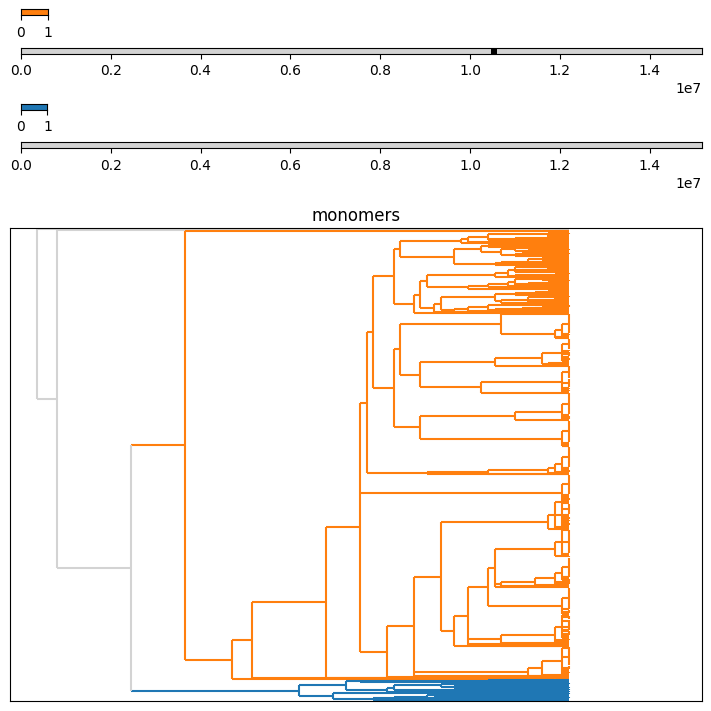

Subtree: [1]
None


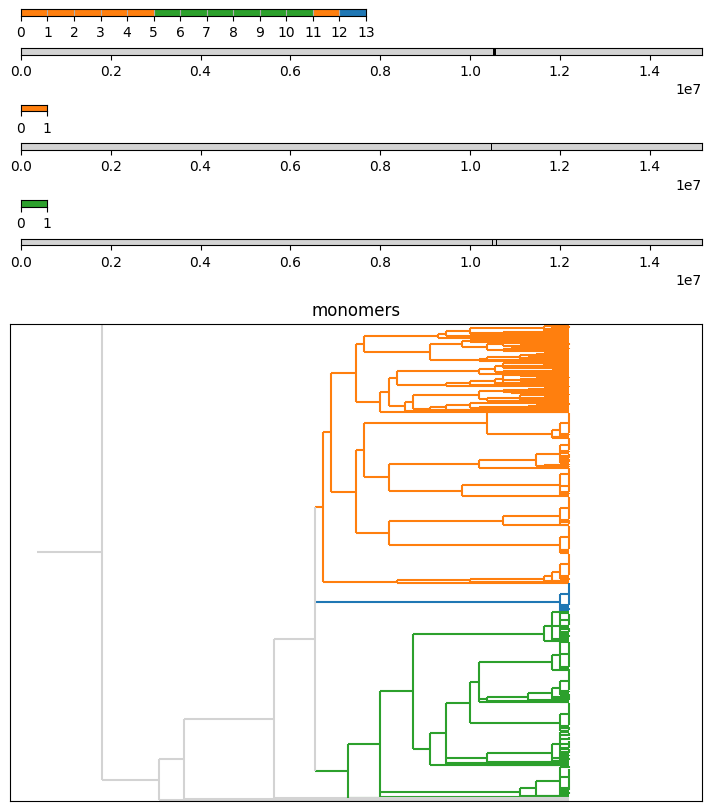

Subtree: [1, 1]
None


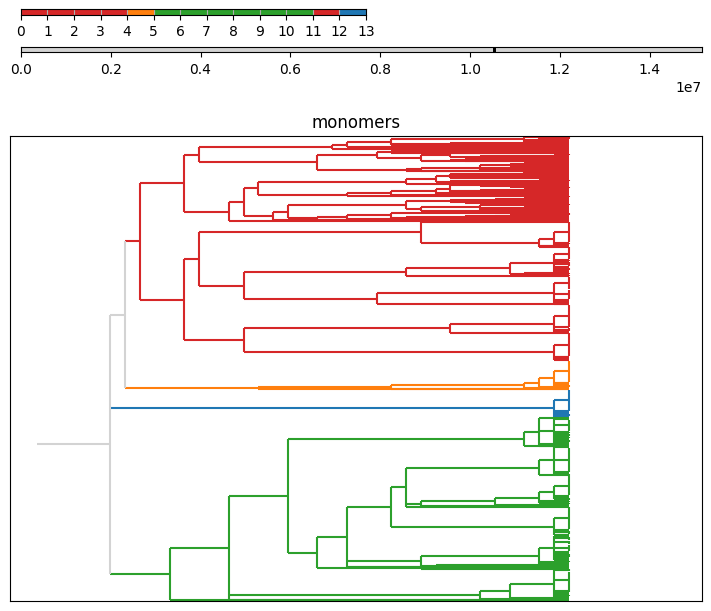

Subtree: [1, 1, 1]
None


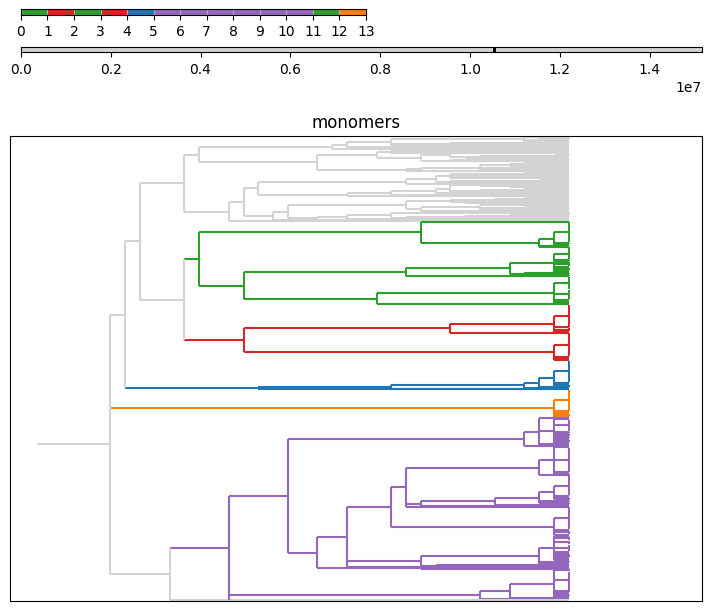

Subtree: [1, 1, 1, 1]
None


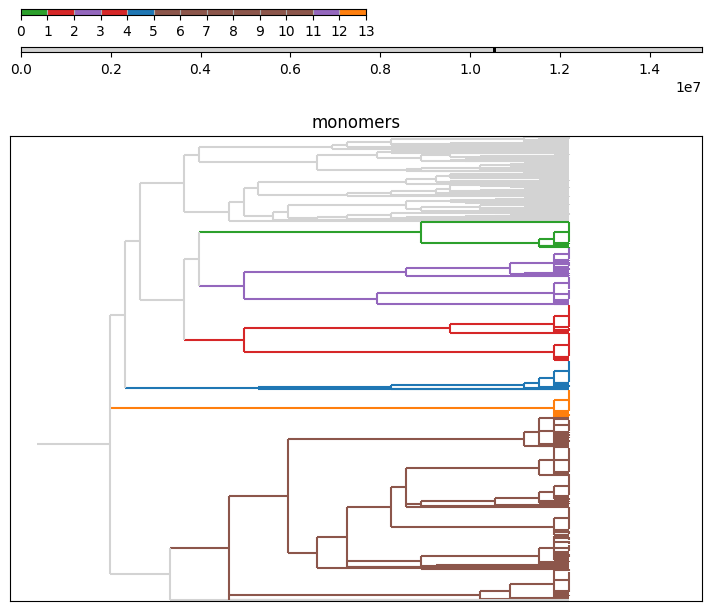

Subtree: [1, 1, 1, 1, 1]
None


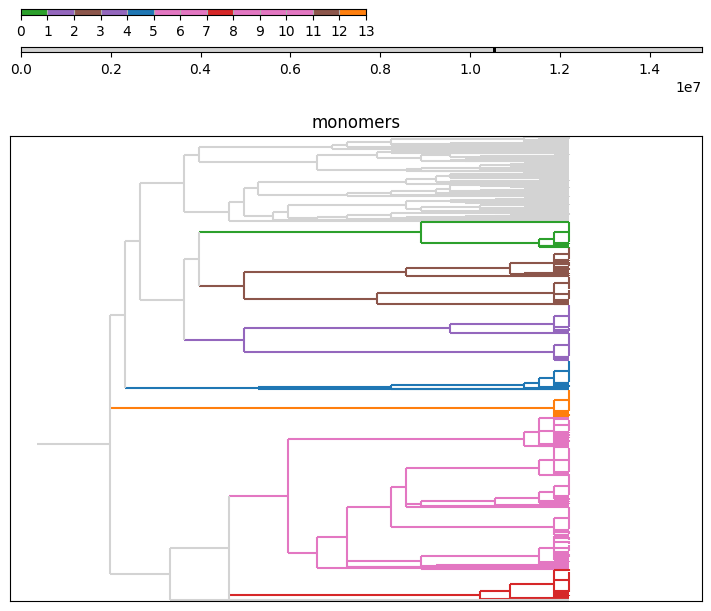

Subtree: [1, 1, 1, 1, 1, 1]
None


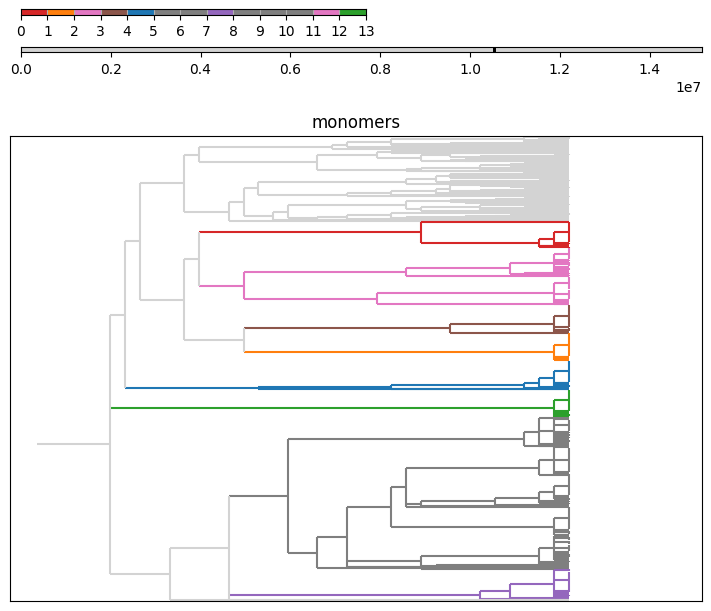

Subtree: [1, 1, 1, 1, 1, 1, 1]
None


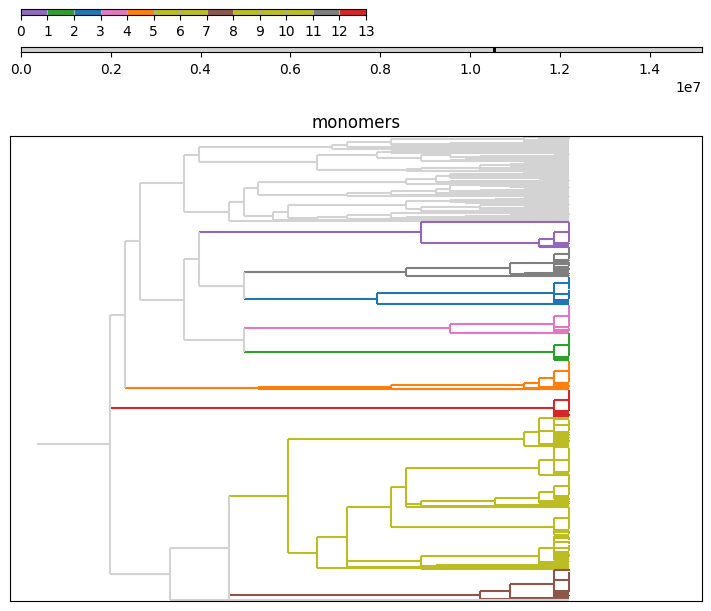

Subtree: [1, 1, 1, 1, 1, 1, 1, 1]
None


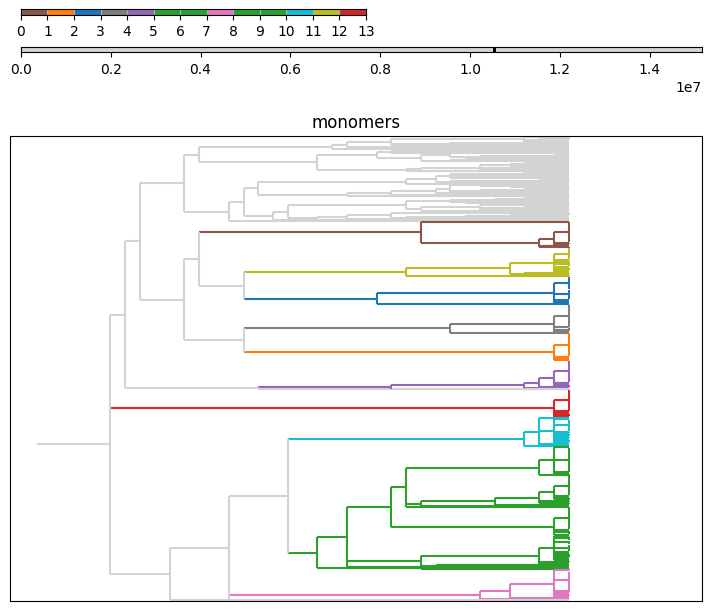

Subtree: [1, 1, 1, 1, 1, 1, 1, 1, 1]
None


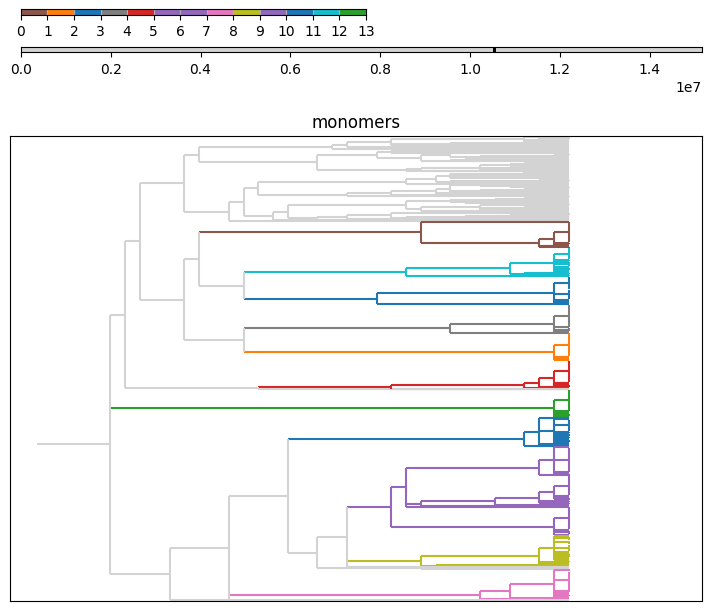

Subtree: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
None


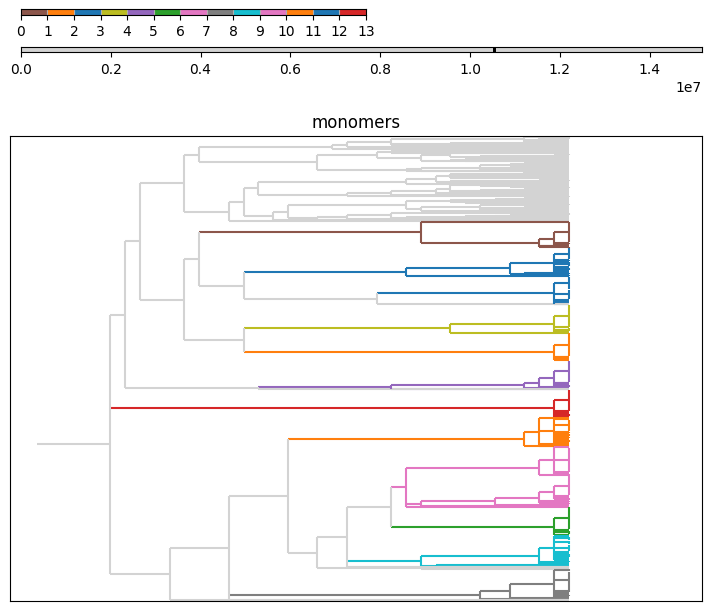

Subtree: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
None


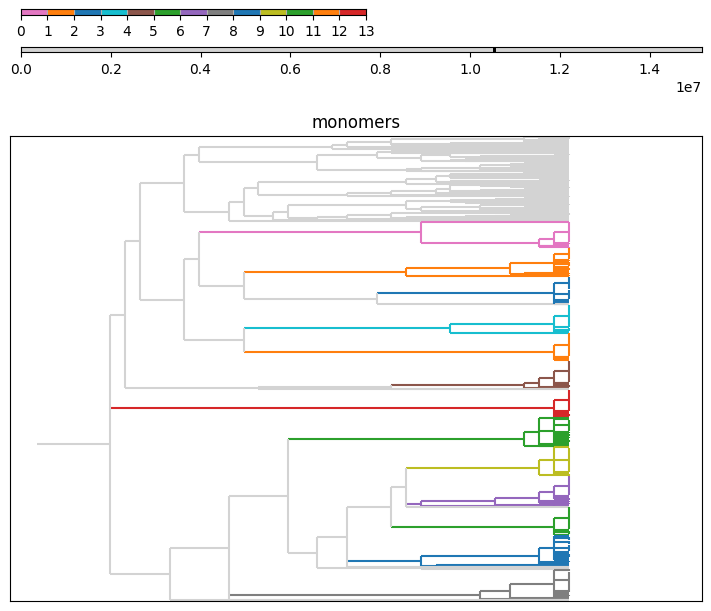

Subtree: [1, 2]
None


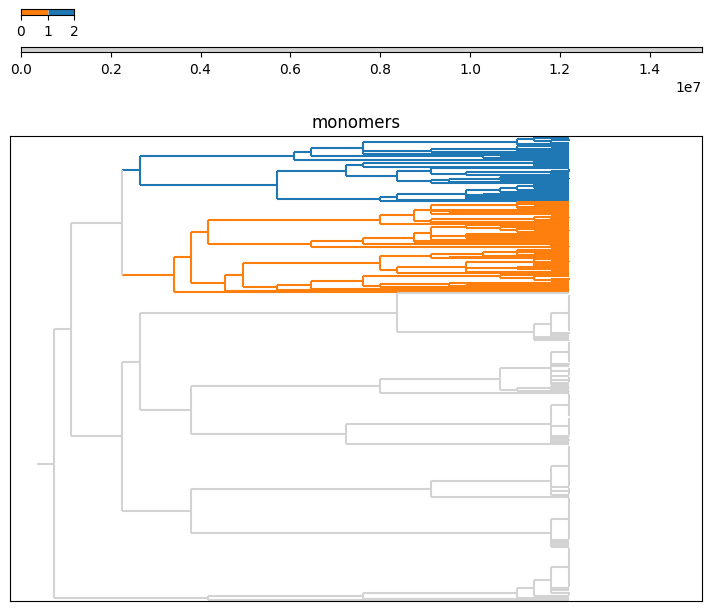

Subtree: [2]
None


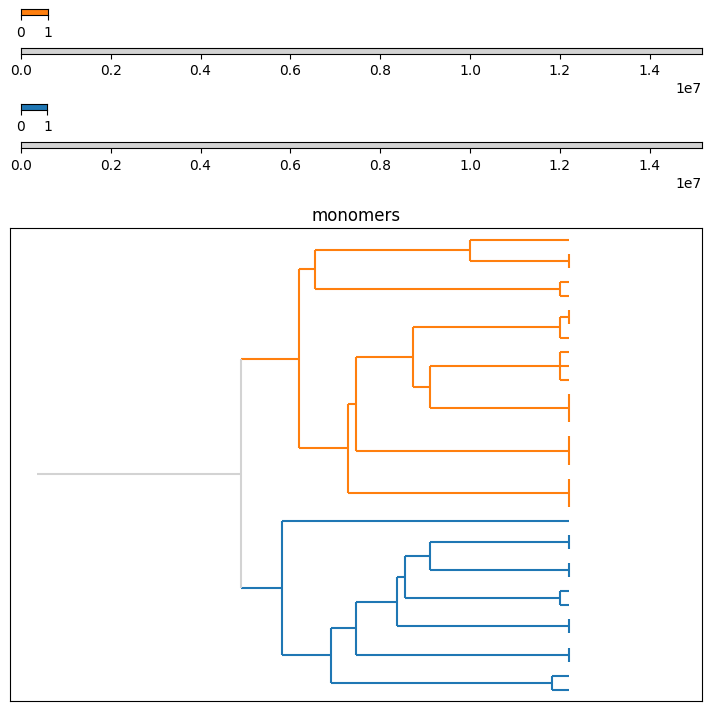

In [17]:
show_hor_tree(hor_tree_root=hor_tree.as_hor_in_seq, reference_seq=references['chr4:44699037-59858846'], tree=phylogeny)

In [18]:
hor_tree_discrete = phylogeny_to_hor_tree(phylogeny, min_loops=5, allow_hor_overlap=False, discrete_sorted_levels=True)

In [19]:
phyloXml = Phyloxml(phylogenies=[hor_tree_discrete.as_phyloxml], attributes=None)
PhyloXMLIO.write(phyloXml, './data/chr4_human/HORs_discrete.xml')

1

Subtree: []
None


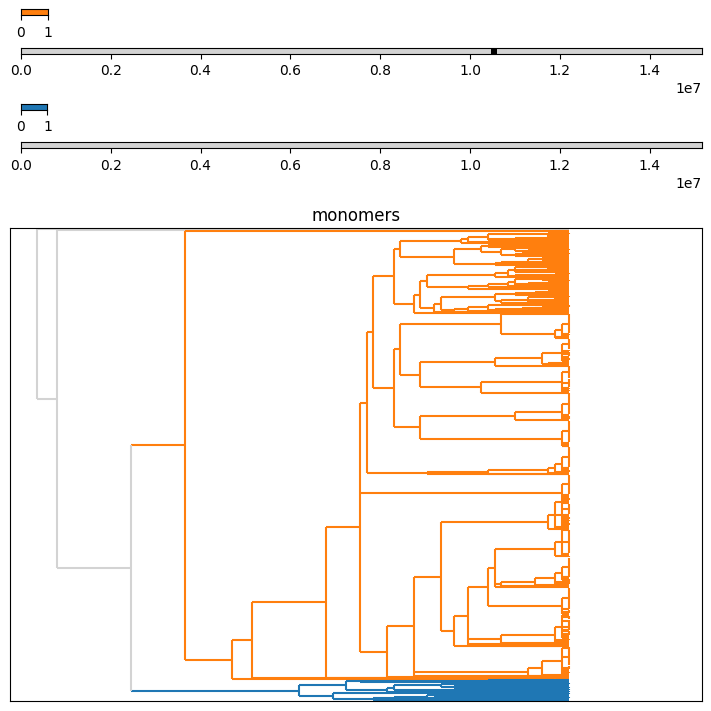

Subtree: [1]
None


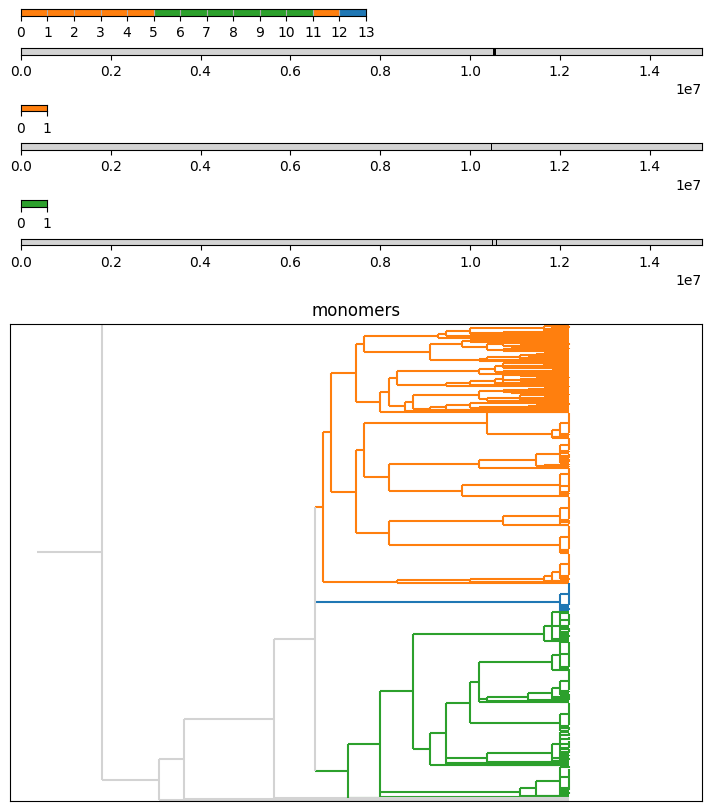

Subtree: [1, 1]
None


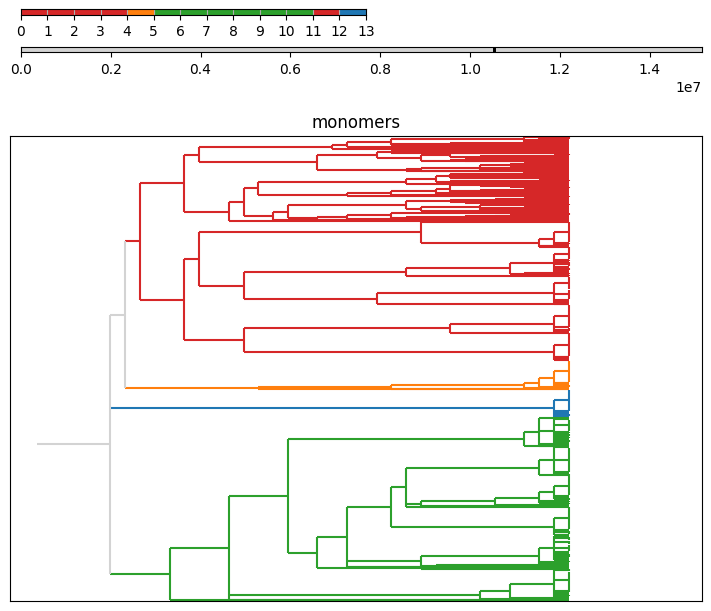

Subtree: [1, 1, 1]
None


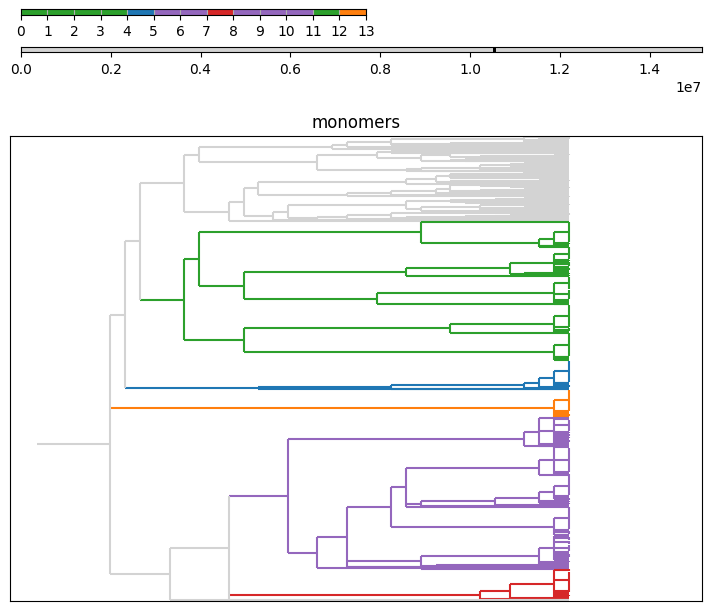

Subtree: [1, 1, 1, 1]
None


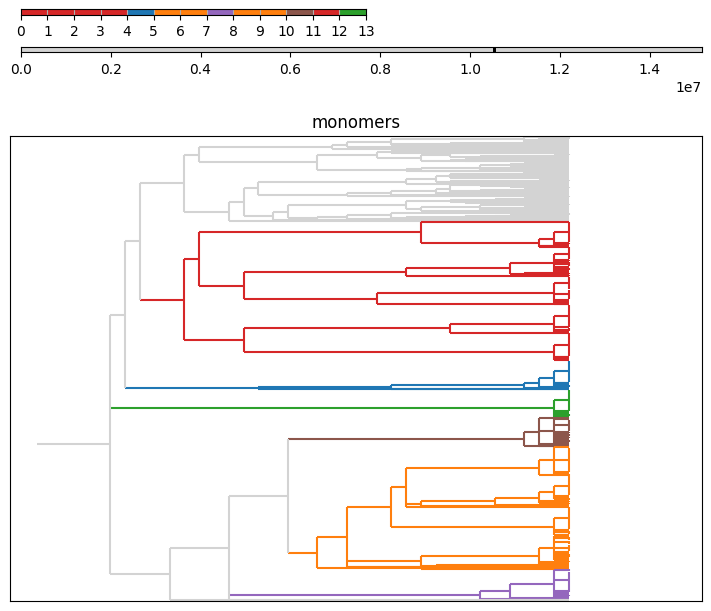

Subtree: [1, 1, 1, 1, 1]
None


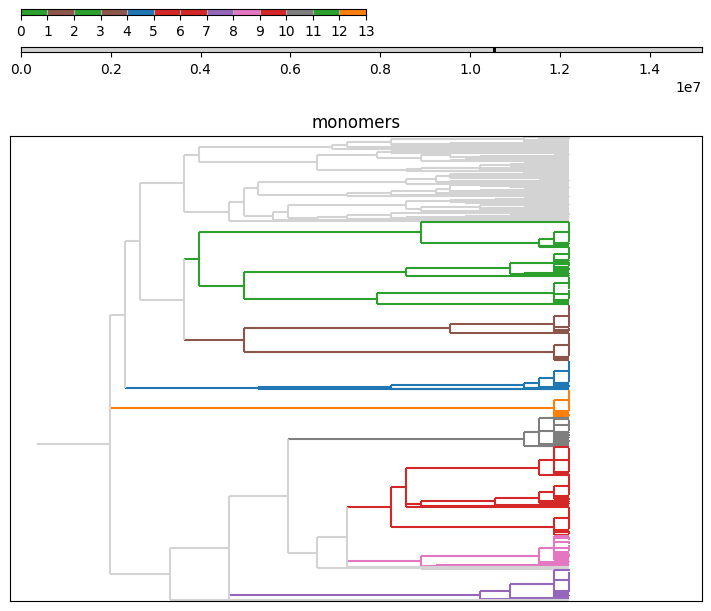

Subtree: [1, 1, 1, 1, 1, 1]
None


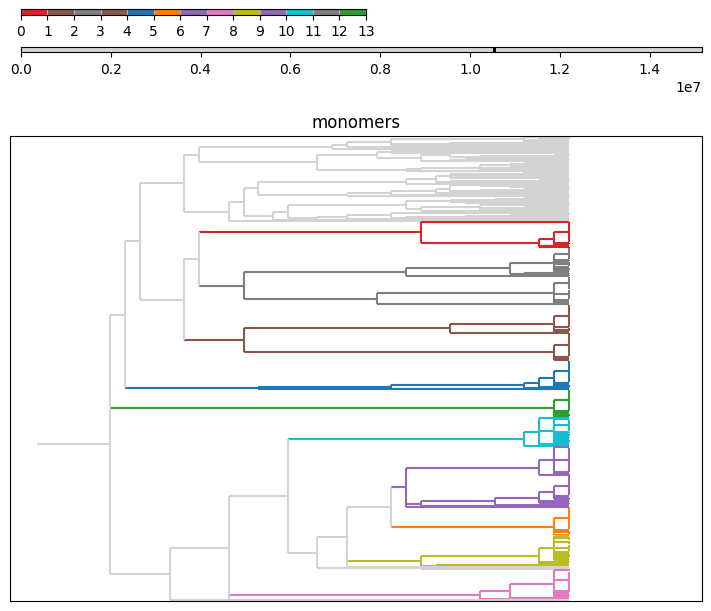

Subtree: [1, 1, 1, 1, 1, 1, 1]
None


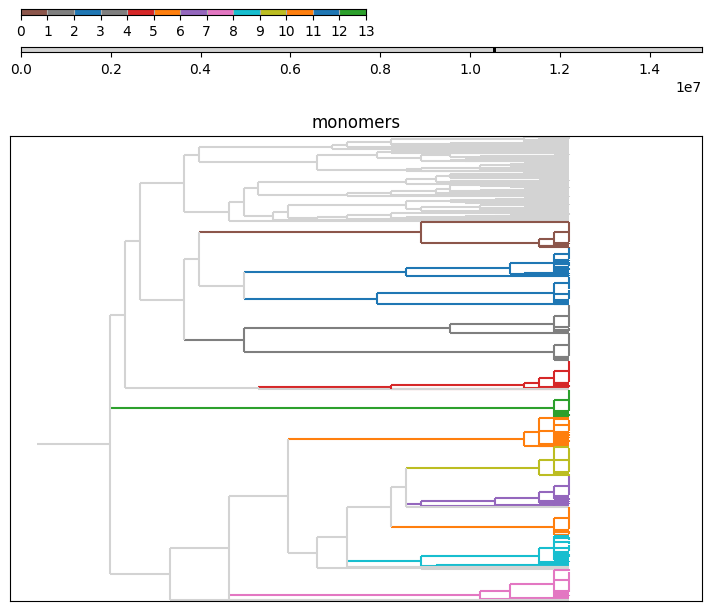

Subtree: [1, 1, 1, 1, 1, 1, 1, 1]
None


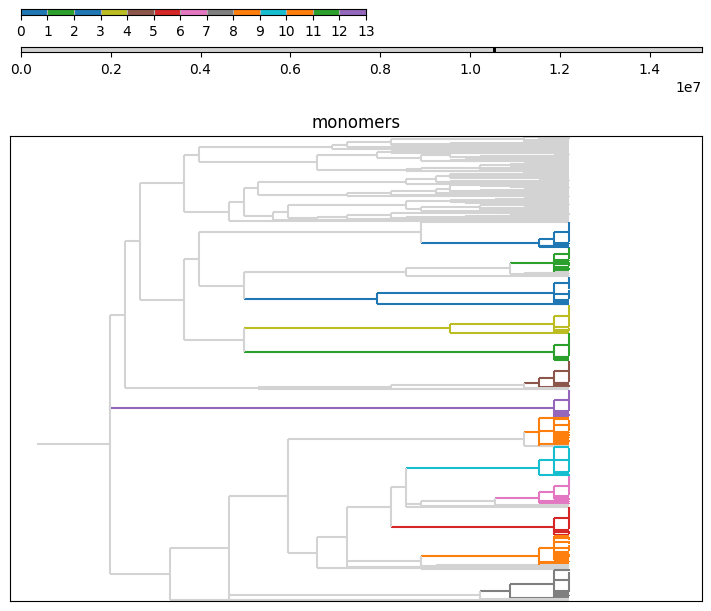

Subtree: [1, 2]
None


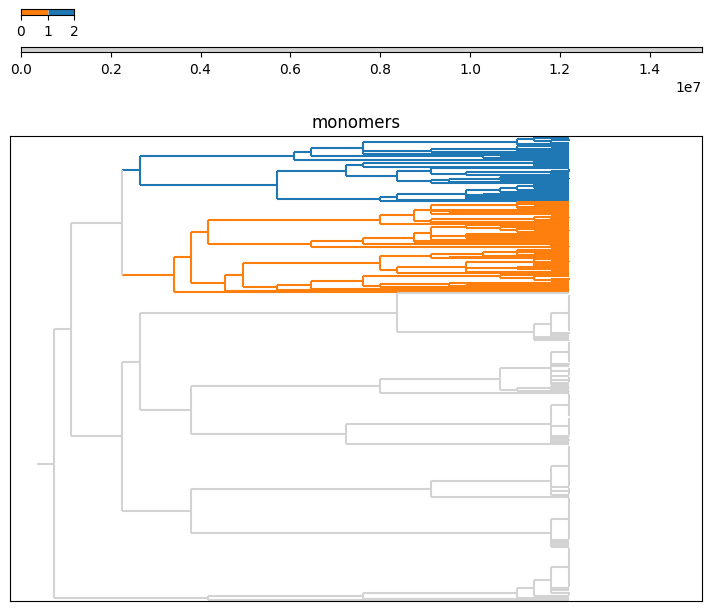

Subtree: [2]
None


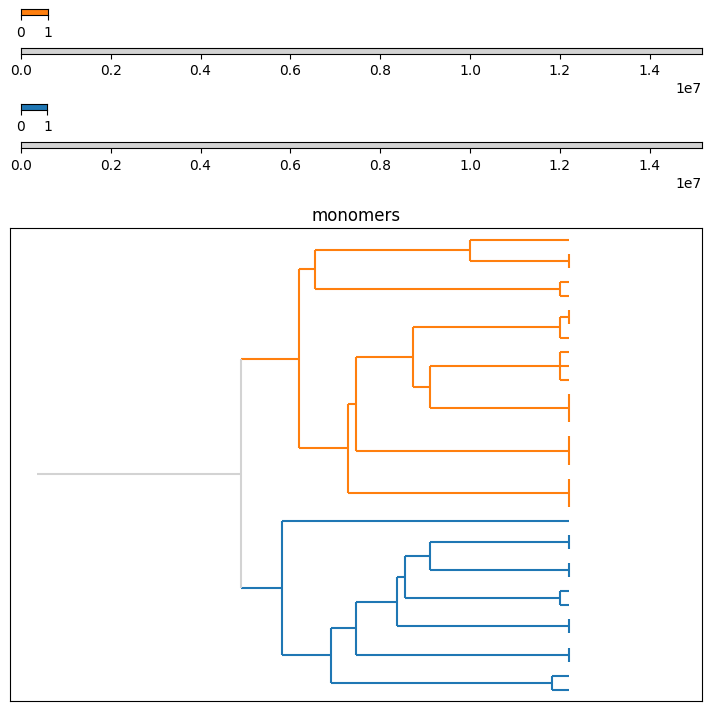

In [20]:
show_hor_tree(hor_tree_root=hor_tree_discrete.as_hor_in_seq, reference_seq=references['chr4:44699037-59858846'], tree=phylogeny)

In [21]:
phylogenies_equal(hor_tree.as_phyloxml, hor_tree_discrete.as_phyloxml, check_branch_lengths=False)

False